## Post-processing Mitigation Methods: AIF360


In [6]:
! pip install aif360
# ! pip install BlackBoxAuditing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fairness_helpers as fh
import utilities
import global_variables as gv

from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

import tensorflow as tf
import keras
from tensorflow.keras.optimizers  import Adam, Adagrad, SGD, RMSprop

from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr
from aif360.sklearn.metrics import generalized_fnr, difference
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
# from common_utils import compute_metrics
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm
from IPython.display import Markdown, display

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

### load model

In [8]:
model = keras.models.load_model('saved_models/mlp_binary_1.h5')
model.compile(loss='binary_crossentropy',
              optimizer=SGD(learning_rate=0.0005),
              metrics=['acc',tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

### get data & convert to AIF360 BinaryLabelDataset

In [9]:
_, X1 = fh.get_aif360_data(colab=True)

# X_train, X_test, y_train, y_test = train_test_split(X1.drop('CVD', axis=1), y, test_size=0.2, shuffle=False)
# X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.15, random_state=1)


In [29]:
# dataset1b = BinaryLabelDataset(df=X1, 
#                           label_names=['CVD'], 
#                           protected_attribute_names=['sex-binary'])

dataset2b = BinaryLabelDataset(df=X1, 
                          label_names=['CVD'], 
                          protected_attribute_names=['race-binary'])

# dataset3b = BinaryLabelDataset(df=X1, 
#                           label_names=['CVD'], 
#                           protected_attribute_names=['age-binary'])

In [30]:
# split into train, validation, and test partitions

# dataset_orig_train1, dataset_orig_vt1 = dataset1b.split([0.6], shuffle=True)
# dataset_orig_valid1, dataset_orig_test1 = dataset1b.split([0.5], shuffle=True)

dataset_orig_train2, dataset_orig_vt2 = dataset2b.split([0.6], shuffle=True)
dataset_orig_valid2, dataset_orig_test2 = dataset2b.split([0.5], shuffle=True)

# dataset_orig_train3, dataset_orig_vt3 = dataset3b.split([0.6], shuffle=True)
# dataset_orig_valid3, dataset_orig_test3 = dataset3b.split([0.5], shuffle=True)

In [12]:
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=1)


In [31]:
# dataset_orig_train1_temp = undersample.fit_resample(dataset_orig_train1.features, dataset_orig_train1.labels)

# dataframe1 = pd.DataFrame(np.append(dataset_orig_train1_temp[0], values=np.expand_dims(dataset_orig_train1_temp[1], axis=1), axis=1), columns=X1.columns.to_list())
# dataset_orig_train1 = BinaryLabelDataset(df=dataframe1, 
#                           label_names=['CVD'], 
#                           protected_attribute_names=['sex-binary'])

# race
dataset_orig_train2_temp = undersample.fit_resample(dataset_orig_train2.features, dataset_orig_train2.labels)

dataframe2 = pd.DataFrame(np.append(dataset_orig_train2_temp[0], values=np.expand_dims(dataset_orig_train2_temp[1], axis=1), axis=1), columns=X1.columns.to_list())
dataset_orig_train2 = BinaryLabelDataset(df=dataframe2, 
                          label_names=['CVD'], 
                          protected_attribute_names=['race-binary'])

# # age
# dataset_orig_train1_temp = undersample.fit_resample(dataset_orig_train1.features, dataset_orig_train1.labels)

# dataframe3 = pd.DataFrame(np.append(dataset_orig_train3_temp[0], values=np.expand_dims(dataset_orig_train3_temp[1], axis=1), axis=1), columns=X1.columns.to_list())
# dataset_orig_train3 = BinaryLabelDataset(df=dataframe3, 
#                           label_names=['CVD'], 
#                           protected_attribute_names=['age-binary'])

In [32]:
# sex
# X_train1 = dataset_orig_train1.features[:,:-4]
# dataset_orig_train1 = dataset_orig_train1.features
# y_train1 = dataset_orig_train1.labels


# X_train1 = dataset_orig_train1.features[:,:-4]
# y_train1 = dataset_orig_train1.labels

# X_val1 = dataset_orig_valid1.features[:,:-4]
# y_val1 = dataset_orig_valid1.labels

# X_test1 = dataset_orig_test1.features[:,:-4]
# y_test1 = dataset_orig_test1.labels

# # race
X_train2 = dataset_orig_train2.features[:,:-4]
y_train2 = dataset_orig_train2.labels

X_val2 = dataset_orig_valid2.features[:,:-4]
y_val2 = dataset_orig_valid2.labels

X_test2 = dataset_orig_test2.features[:,:-4]
y_test2 = dataset_orig_test2.labels

# # age
# X_train3 = dataset_orig_train3.features[:,:-4]
# y_train3 = dataset_orig_train3.labels

# X_val3 = dataset_orig_valid3.features[:,:-4]
# y_val3 = dataset_orig_valid3.labels

# X_test3 = dataset_orig_test3.features[:,:-4]
# y_test3 = dataset_orig_test3.labels

#### get original predictions

In [15]:
# sex
model.fit(X_train1, y_train1)
y_train_pred_prob1 = model.predict(X_train1)
y_val_pred_prob1 = model.predict(X_val1)
y_test_pred_prob1 = model.predict(X_test1)

1730/1730 [==============================] - 11s 6ms/step - loss: 0.5985 - acc: 0.6851 - auc_1: 0.7460 - recall_1: 0.6939


In [33]:
# race
model.fit(X_train2, y_train2)
y_train_pred_prob2 = model.predict(X_train2)
y_val_pred_prob2 = model.predict(X_val2)
y_test_pred_prob2 = model.predict(X_test2)

1743/1743 [==============================] - 10s 6ms/step - loss: 0.5948 - acc: 0.6877 - auc_1: 0.7491 - recall_1: 0.6944


In [11]:
# age
model.fit(X_train3, y_train3)
y_train_pred_prob3 = model.predict(X_train3)
y_val_pred_prob3 = model.predict(X_val3)
y_test_pred_prob3 = model.predict(X_test3)

9422/9422 [==============================] - 56s 6ms/step - loss: 0.2718 - acc: 0.9073 - auc_1: 0.7555 - recall_1: 0.0064


In [34]:
class_thresh = 0.609388

# # Placeholder for predicted and transformed datasets (sex)
# dataset_orig_train_pred1 = dataset_orig_train1.copy(deepcopy=True)
# dataset_orig_valid_pred1 = dataset_orig_valid1.copy(deepcopy=True)
# dataset_orig_test_pred1 = dataset_orig_test1.copy(deepcopy=True)

# # insert prediction scores
# dataset_orig_train_pred1.scores = y_train_pred_prob1.reshape(-1,1)
# dataset_orig_valid_pred1.scores = y_val_pred_prob1.reshape(-1,1)
# dataset_orig_test_pred1.scores = y_test_pred_prob1.reshape(-1,1)

# # get labels from probabilities
# y_train_pred1 = np.zeros_like(dataset_orig_train_pred1.labels)
# y_train_pred1[y_train_pred_prob1 >= class_thresh] = dataset_orig_train_pred1.favorable_label
# y_train_pred1[~(y_train_pred_prob1 >= class_thresh)] = dataset_orig_train_pred1.unfavorable_label
# dataset_orig_train_pred1.labels = y_train_pred1

# y_valid_pred1 = np.zeros_like(dataset_orig_valid_pred1.labels)
# y_valid_pred1[y_val_pred_prob1 >= class_thresh] = dataset_orig_valid_pred1.favorable_label
# y_valid_pred1[~(y_val_pred_prob1 >= class_thresh)] = dataset_orig_valid_pred1.unfavorable_label
# dataset_orig_valid_pred1.labels = y_valid_pred1
    
# y_test_pred1 = np.zeros_like(dataset_orig_test_pred1.labels)
# y_test_pred1[y_test_pred_prob1 >= class_thresh] = dataset_orig_test_pred1.favorable_label
# y_test_pred1[~(y_test_pred_prob1 >= class_thresh)] = dataset_orig_test_pred1.unfavorable_label
# dataset_orig_test_pred1.labels = y_test_pred1




# # Placeholder for predicted and transformed datasets (race)
dataset_orig_train_pred2 = dataset_orig_train2.copy(deepcopy=True)
dataset_orig_valid_pred2 = dataset_orig_valid2.copy(deepcopy=True)
dataset_orig_test_pred2 = dataset_orig_test2.copy(deepcopy=True)

# insert prediction scores
dataset_orig_train_pred2.scores = y_train_pred_prob2.reshape(-1,1)
dataset_orig_valid_pred2.scores = y_val_pred_prob2.reshape(-1,1)
dataset_orig_test_pred2.scores = y_test_pred_prob2.reshape(-1,1)

# get labels from probabilities
y_train_pred2 = np.zeros_like(dataset_orig_train_pred2.labels)
y_train_pred2[y_train_pred_prob2 >= class_thresh] = dataset_orig_train_pred2.favorable_label
y_train_pred2[~(y_train_pred_prob2 >= class_thresh)] = dataset_orig_train_pred2.unfavorable_label
dataset_orig_train_pred2.labels = y_train_pred2

y_valid_pred2 = np.zeros_like(dataset_orig_valid_pred2.labels)
y_valid_pred2[y_val_pred_prob2 >= class_thresh] = dataset_orig_valid_pred2.favorable_label
y_valid_pred2[~(y_val_pred_prob2 >= class_thresh)] = dataset_orig_valid_pred2.unfavorable_label
dataset_orig_valid_pred2.labels = y_valid_pred2
    
y_test_pred2 = np.zeros_like(dataset_orig_test_pred2.labels)
y_test_pred2[y_test_pred_prob2 >= class_thresh] = dataset_orig_test_pred2.favorable_label
y_test_pred2[~(y_test_pred_prob2 >= class_thresh)] = dataset_orig_test_pred2.unfavorable_label
dataset_orig_test_pred2.labels = y_test_pred2



# # Placeholder for predicted and transformed datasets (age)
# dataset_orig_train_pred3 = dataset_orig_train3.copy(deepcopy=True)
# dataset_orig_valid_pred3 = dataset_orig_valid3.copy(deepcopy=True)
# dataset_orig_test_pred3 = dataset_orig_test3.copy(deepcopy=True)

# # insert prediction scores
# dataset_orig_train_pred3.scores = y_train_pred_prob3.reshape(-1,1)
# dataset_orig_valid_pred3.scores = y_val_pred_prob3.reshape(-1,1)
# dataset_orig_test_pred3.scores = y_test_pred_prob3.reshape(-1,1)

# # get labels from probabilities
# y_train_pred3 = np.zeros_like(dataset_orig_train_pred3.labels)
# y_train_pred3[y_train_pred_prob3 >= class_thresh] = dataset_orig_train_pred3.favorable_label
# y_train_pred3[~(y_train_pred_prob3 >= class_thresh)] = dataset_orig_train_pred3.unfavorable_label
# dataset_orig_train_pred3.labels = y_train_pred3

# y_valid_pred3 = np.zeros_like(dataset_orig_valid_pred3.labels)
# y_valid_pred3[y_val_pred_prob3 >= class_thresh] = dataset_orig_valid_pred3.favorable_label
# y_valid_pred3[~(y_val_pred_prob3 >= class_thresh)] = dataset_orig_valid_pred3.unfavorable_label
# dataset_orig_valid_pred3.labels = y_valid_pred3
    
# y_test_pred3 = np.zeros_like(dataset_orig_test_pred3.labels)
# y_test_pred3[y_test_pred_prob3 >= class_thresh] = dataset_orig_test_pred3.favorable_label
# y_test_pred3[~(y_test_pred_prob3 >= class_thresh)] = dataset_orig_test_pred3.unfavorable_label
# dataset_orig_test_pred3.labels = y_test_pred3

### Method 1. Calibrated Equalized Odds Post-processing

Optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective

#### construct calibrated classifier for each protected attribute & constraint (FNR & weighted(fnr/fpr))

In [17]:
# cost constraint of fnr will optimize generalized false negative rates, that of
# fpr will optimize generalized false positive rates, and weighted will optimize
# a weighted combination of both
cost_constraint_fnr = "fnr" # "fnr", "fpr", "weighted"
cost_constraint_weighted = "weighted"
randseed = 156

In [18]:
p1, u1 = fh.get_att_privilege_groups('sex-binary')
p2, u2 = fh.get_att_privilege_groups('race-binary')
p3, u3 = fh.get_att_privilege_groups('age-binary')

In [35]:
# Learn parameters to equalize odds and apply to create a new dataset

# fnr constraint
# cpp_sex_fnr = CalibratedEqOddsPostprocessing(privileged_groups = p1,
#                                      unprivileged_groups = u1,
#                                      cost_constraint=cost_constraint_fnr,
#                                      seed=randseed)

cpp_race_fnr = CalibratedEqOddsPostprocessing(privileged_groups = p2,
                                     unprivileged_groups = u2,
                                     cost_constraint=cost_constraint_fnr,
                                     seed=randseed)

# cpp_age_fnr = CalibratedEqOddsPostprocessing(privileged_groups = p3,
#                                      unprivileged_groups = u3,
#                                      cost_constraint=cost_constraint_fnr,
#                                      seed=randseed)

# weighted constraint
# cpp_sex_weighted = CalibratedEqOddsPostprocessing(privileged_groups = p1,
#                                      unprivileged_groups = u1,
#                                      cost_constraint=cost_constraint_weighted,
#                                      seed=randseed)

# cpp_race_weighted = CalibratedEqOddsPostprocessing(privileged_groups = p2,
#                                      unprivileged_groups = u2,
#                                      cost_constraint=cost_constraint_weighted,
#                                      seed=randseed)

# cpp_age_weighted = CalibratedEqOddsPostprocessing(privileged_groups = p3,
#                                      unprivileged_groups = u3,
#                                      cost_constraint=cost_constraint_weighted,
#                                      seed=randseed)

#### perform odds equalizing post processing on scores

In [21]:
# sex
cpp_sex_fnr = cpp_sex_fnr.fit(dataset_orig_valid1, dataset_orig_valid_pred1)
# cpp_sex_weighted = cpp_sex_weighted.fit(dataset_orig_valid1, dataset_orig_valid_pred1)

In [37]:
# race
cpp_race_fnr = cpp_race_fnr.fit(dataset_orig_valid2, dataset_orig_valid_pred2)
# cpp_race_weighted = cpp_race_weighted.fit(dataset_orig_valid2, dataset_orig_valid_pred2)

In [18]:
# age 
cpp_age_fnr = cpp_age_fnr.fit(dataset_orig_valid3, dataset_orig_valid_pred3)
cpp_age_weighted = cpp_age_weighted.fit(dataset_orig_valid3, dataset_orig_valid_pred3)

### transform validation and test data using the post processing algorithm

In [38]:
# sex fnr transform
# dataset_transf_valid_pred11 = cpp_sex_fnr.predict(dataset_orig_valid_pred1)
# dataset_transf_test_pred11 = cpp_sex_fnr.predict(dataset_orig_test_pred1)

# sex weighted transform
# dataset_transf_valid_pred12 = cpp_sex_weighted.predict(dataset_orig_valid_pred1)
# dataset_transf_test_pred12 = cpp_sex_weighted.predict(dataset_orig_test_pred1)

# # race fnr transform
dataset_transf_valid_pred21 = cpp_race_fnr.predict(dataset_orig_valid_pred2)
dataset_transf_test_pred21 = cpp_race_fnr.predict(dataset_orig_test_pred2)

# # race weighted transform
# dataset_transf_valid_pred22 = cpp_race_weighted.predict(dataset_orig_valid_pred2)
# dataset_transf_test_pred22 = cpp_race_weighted.predict(dataset_orig_test_pred2)

# # age fnr transform
# dataset_transf_valid_pred31 = cpp_age_fnr.predict(dataset_orig_valid_pred3)
# dataset_transf_test_pred31 = cpp_age_fnr.predict(dataset_orig_test_pred3)

# # age weighted transform
# dataset_transf_valid_pred32 = cpp_age_weighted.predict(dataset_orig_valid_pred3)
# dataset_transf_test_pred32 = cpp_age_weighted.predict(dataset_orig_test_pred3)

## Plot Calibrated Equalized Odds Results

In [ ]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh1 = dataset_orig_valid_pred2.copy(deepcopy=True)
    dataset_orig_test_pred_thresh1 = dataset_orig_test_pred2.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh1 = dataset_transf_valid_pred21.copy(deepcopy=True)
    dataset_transf_test_pred_thresh1 = dataset_transf_test_pred21.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh1.labels)
    y_temp[dataset_orig_valid_pred_thresh1.scores >= thresh] = dataset_orig_valid_pred_thresh1.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh1.scores >= thresh)] = dataset_orig_valid_pred_thresh1.unfavorable_label
    dataset_orig_valid_pred_thresh1.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh1.labels)
    y_temp[dataset_orig_test_pred_thresh1.scores >= thresh] = dataset_orig_test_pred_thresh1.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh1.scores >= thresh)] = dataset_orig_test_pred_thresh1.unfavorable_label
    dataset_orig_test_pred_thresh1.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh1.labels)
    y_temp[dataset_transf_valid_pred_thresh1.scores >= thresh] = dataset_transf_valid_pred_thresh1.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh1.scores >= thresh)] = dataset_transf_valid_pred_thresh1.unfavorable_label
    dataset_transf_valid_pred_thresh1.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh1.labels)
    y_temp[dataset_transf_test_pred_thresh1.scores >= thresh] = dataset_transf_test_pred_thresh1.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh1.scores >= thresh)] = dataset_transf_test_pred_thresh1.unfavorable_label
    dataset_transf_test_pred_thresh1.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid2,
                                                 dataset_orig_valid_pred_thresh1,
                                                 unprivileged_groups=u2,
                                                 privileged_groups=p2)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test2,
                                                 dataset_orig_test_pred_thresh1,
                                                 unprivileged_groups=u2,
                                                 privileged_groups=p2)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_valid2, 
                                     dataset_transf_valid_pred_thresh1,
                                     unprivileged_groups=u2,
                                     privileged_groups=p2)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf testing data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test2,
                                                 dataset_transf_test_pred_thresh1,
                                                 unprivileged_groups=u2,
                                                 privileged_groups=p2)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))

#### Classification thresholds used for validation and parameter selection

  4%|▍         | 1/25 [00:07<03:04,  7.68s/it]

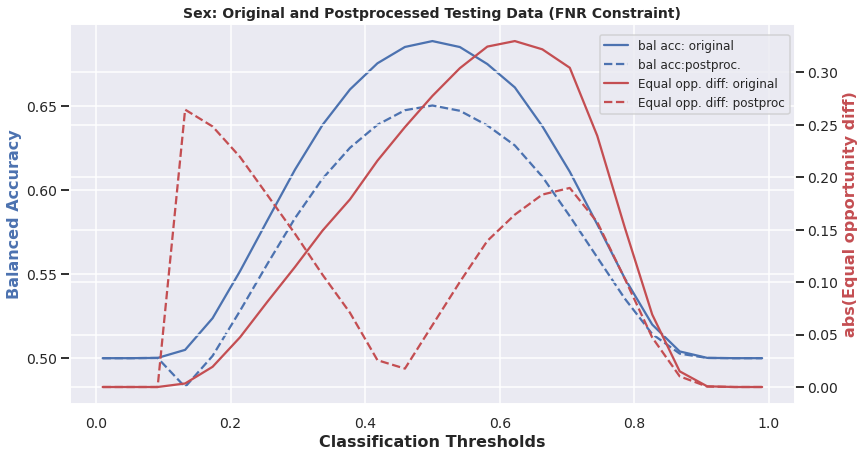

In [28]:
sns.set(context='talk', style='darkgrid')
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Sex: Original and Postprocessed Testing Data (FNR Constraint)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["bal acc: original", "bal acc:postproc.",
             "Equal opp. diff: original","Equal opp. diff: postproc",], 
           fontsize=12, bbox_to_anchor=(0.85, 0.85))

In [ ]:
sns.set(context='talk', style='darkgrid')
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Race: Original and Postprocessed Testing Data (FNR Constraint)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["bal acc: original", "bal acc:postproc.",
             "Equal opp. diff: original","Equal opp. diff: postproc",], 
           fontsize=12, bbox_to_anchor=(0.85, 0.85))

### get results for all metrics (sex fnr)

In [ ]:
# classified_metric_transf_test

TPR = classified_metric.true_positive_rate()
TNR = classified_metric.true_negative_rate()
bal_acc = 0.5*(TPR+TNR)

acc = accuracy_score(y_true=dataset.labels,
                      y_pred=dataset_pred.labels)
bal_acc_arr.append(bal_acc)
TPR_arr.append(TPR)
TNR_arr.append(TNR)
avg_odds_diff_arr.append(classified_metric.average_odds_difference())
disp_imp_arr.append(metric_pred.disparate_impact())
stat_par_diff.append(classified_metric.statistical_parity_difference())
eq_opp_diff.append(classified_metric.equal_opportunity_difference())
theil_ind.append(classified_metric.theil_index())

#### alternative method

In [ ]:
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=1234567)
log_reg = LogisticRegression(solver='lbfgs')
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds, random_state=1234567)

postproc.fit(X_train, y_train)
accuracy_score(y_test, postproc.predict(X_test))

In [ ]:
y_pred = postproc.predict_proba(X_test)[:, 1]
y_lr = postproc.estimator_.predict_proba(X_test)[:, 1]
br = postproc.postprocessor_.base_rates_
i = X_test.index.get_level_values('sex-binary') == 1

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Females)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='b', marker='.', label='Original classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='r', marker='.', label='Original classifier (Males)')
                                                                        
plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='b', marker='d', label='Post-processed classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='r', marker='d', label='Post-processed classifier (Males)')

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.axis('square')
plt.xlim([0.0, 0.4])
plt.ylim([0.3, 0.7])
plt.xlabel('generalized fpr');
plt.ylabel('generalized fnr');
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');

In [ ]:
difference(generalized_fnr, y_test, y_pred, prot_attr='sex')

### Method 2.  Equalized Odds Post-Processing

Solves a linear program to find probabilities with which to change output labels to optimize equalized odds

### Method 3. Reject Option Classification

Gives favorable outcomes ot unprivileged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty

> The debiasing function used is implemented in the RejectOptionClassification class.
- Divide the dataset into training, validation, and testing partitions.
- Train classifier on original training data.
- Estimate the optimal classification threshold, that maximizes balanced accuracy without fairness constraints.
- Estimate the optimal classification threshold, and the critical region boundary (ROC margin) using a validation set for the desired constraint on fairness. The best parameters are those that maximize the classification threshold while satisfying the fairness constraints.
- The constraints can be used on the following fairness measures:
          - Statistical parity difference on the predictions of the classifier
          - Average odds difference for the classifier
          - Equal opportunity difference for the classifier
- Determine the prediction scores for testing data. Using the estimated optimal classification threshold, compute accuracy and fairness metrics.
- Using the determined optimal classification threshold and the ROC margin, adjust the predictions. Report accuracy and fairness metric on the new predictions.

#### estimate optimal parameters for the ROC method

In [ ]:
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [ ]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)